In [1]:
import subprocess as sb
import os
import glob
import nibabel
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

%matplotlib inline

Outline
- Load image and determine
- Load surface files
- Overlay image and surface files

In [2]:
subjDir = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/"

In [3]:
# subjs = [i for i in os.listdir(subjDir) if "sub-" in i]
# print(len(subjs))

596


In [4]:
# FS_folder = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/"

In [5]:
def selectSliceIndices(brainMin, brainMax):
    # Get the slices for each dimension
    slice1 = int((brainMax - brainMin)/4 + brainMin + random.randint(-12, 12))
    slice2 = int((brainMax - brainMin)/2 + brainMin + random.randint(-12, 12))
    slice3 = int((brainMax - brainMin)*3/4 + brainMin + random.randint(-12, 12))
    
    return [slice1, slice2, slice3]

def selectBrainSlices(folder):
    # Load the masked brain image
    nibImg = nibabel.load(FS_folder+"mri/norm.mgz")
    img = nibImg.get_fdata()

    # # What volumes do we want? 
    # # Third dim: 0 is back of head? max is front of head? AP view
    # # Second dim: coronal, 0 is top and max is bottom of skull
    # # First dim: sagittal? LR

    # Goal: identify volume of brain that's non-zero
    # Get the upper and lower bounds of brain in each dimension
    dim0Lims, dim1Lims = np.where(img.any(axis=2))
    _, dim2Lims = np.where(img.any(axis=1))

    # Get the min and max of each dimension
    dim0MinBrain = sorted(set(dim0Lims))[0]
    dim0MaxBrain = sorted(set(dim0Lims))[-1]
    dim1MinBrain = sorted(set(dim1Lims))[0]
    dim1MaxBrain = sorted(set(dim1Lims))[-1]
    dim2MinBrain = sorted(set(dim2Lims))[0]
    dim2MaxBrain = sorted(set(dim2Lims))[-1]

    dim0Slices = selectSliceIndices(dim0MinBrain, dim0MaxBrain)
#     plt.figure()
#     plt.imshow(img[dim0Slices[0], :, :])
#     plt.figure()
#     plt.imshow(img[dim0Slices[1], :, :])
#     plt.figure()
#     plt.imshow(img[dim0Slices[2], :, :])

    dim1Slices = selectSliceIndices(dim1MinBrain, dim1MaxBrain)
#     plt.figure()
#     plt.imshow(img[:, dim1Slices[0], :])
#     plt.figure()
#     plt.imshow(img[:, dim1Slices[1], :])
#     plt.figure()
#     plt.imshow(img[:, dim1Slices[2], :])

    dim2Slices = selectSliceIndices(dim2MinBrain, dim2MaxBrain)
#     plt.figure()
#     plt.imshow(img[:, :, dim2Slices[0]])
#     plt.figure()
#     plt.imshow(img[:, :, dim2Slices[1]])
#     plt.figure()
#     plt.imshow(img[:, :, dim2Slices[2]])
    
    return [dim0Slices, dim1Slices, dim2Slices]



In [6]:
##################################################################################################################
#
#   This script uses freeview to make screenshots of a freesurfer segmentation.
#   These screenshots are then combined to a movie, for easy diagnosis of 
#   FreeSurfer segmentation problems. I have chosen for sagittal orientation, 
#   because this allows one to see whether the sagittal sinus is misclassified as V1 gray matter. 
#
#   Adapted from: https://gist.github.com/tknapen/85d9a23a09c95d15f4b23ba1965fa54d
# 
##################################################################################################################

def generatePngsSingleScan(FS_folder, subject, outputDir):
    freeview_command = 'freeview -cmd {cmd} '
    cmd_txt = """ -v {anatomy}:grayscale=10,100 -f {lh_wm}:color=blue:edgecolor=blue -f {rh_wm}:color=blue:edgecolor=blue -f {lh_pial}:color=red:edgecolor=red -f {rh_pial}:color=red:edgecolor=red
     -viewport sagittal
     """  

    # To step through the sagittal slices this is added for every slice. 
    dim0_slice = ' -slice {xpos} 127 127 \n -ss {opfn} \n  '  
    dim1_slice = ' -slice 127 {xpos} 127 \n -ss {opfn} \n  '  
    dim2_slice = ' -slice 127 127 {xpos} \n -ss {opfn} \n  '  

    # Set up variables 
    mprFn = os.path.join(FS_folder, 'mri', 'norm.mgz')          # Want to use the images without the face
#     target_directory = os.path.join(FS_folder, 'pngs')          # Directory to save the pngs to
    target_directory = outputDir
    os.makedirs(target_directory, exist_ok=True)
    cmd_file = os.path.join(target_directory, 'cmd.txt')

    # Start writing the command string
    sj_cmd = cmd_txt.format(
        anatomy=mprFn,
        lh_wm=os.path.join(FS_folder, 'surf', 'lh.white'),
        lh_pial=os.path.join(FS_folder, 'surf', 'lh.pial'),
        rh_wm=os.path.join(FS_folder, 'surf', 'rh.white'),
        rh_pial=os.path.join(FS_folder, 'surf', 'rh.pial'),
        subject=subject
    )

    brainSlices = selectBrainSlices(mprFn)

    for dim0Slice in brainSlices[0]:
        sj_cmd += dim0_slice.format(
            xpos=dim0Slice,
            opfn=os.path.join(target_directory, subject+"_dim0_"+str(
                dim0Slice).zfill(3) + '.png')
        )

    for dim1Slice in brainSlices[1]:
        sj_cmd += dim1_slice.format(
            xpos=dim1Slice,
            opfn=os.path.join(target_directory, subject+"_dim1_"+str(
                dim1Slice).zfill(3) + '.png')
        )

    for dim2Slice in brainSlices[2]:
        sj_cmd += dim2_slice.format(
            xpos=dim2Slice,
            opfn=os.path.join(target_directory, subject+"_dim2_"+str(
                dim2Slice).zfill(3) + '.png') 
        )

    # Add the end of the command
    sj_cmd += ' -quit \n '

    with open(cmd_file, 'w') as f:
        f.write(sj_cmd)

    sb.call(freeview_command.format(cmd=cmd_file), shell=True)
    
    print("PNGs generated for", subject)

2022-05-26 10:22:02.837 Freeview[61489:16530422] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM9101719S


2022-05-26 10:22:30.759 Freeview[61555:16531694] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM910CW92X


/var/folders/cq/ht52y9b14l73vz1j2vqy4lvxky38mb/T/ipykernel_61471/4262650085.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
2022-05-26 10:22:59.207 Freeview[61629:16532977] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM9113J81T


2022-05-26 10:23:24.966 Freeview[61673:16534101] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM911S4IU5


2022-05-26 10:23:51.386 Freeview[61711:16535121] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM912BSG4S


2022-05-26 10:24:18.945 Freeview[61739:16536195] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM912VMDWB


2022-05-26 10:24:44.780 Freeview[61806:16537767] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM91323EAL


2022-05-26 10:25:10.581 Freeview[61836:16538760] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM91349B16


2022-05-26 10:25:37.938 Freeview[61884:16539842] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM913IIEG8


2022-05-26 10:26:04.415 Freeview[61942:16541511] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


PNGs generated for sub-HM913N88SR


2022-05-26 10:26:31.774 Freeview[62069:16542977] *** WARNING: Method userSpaceScaleFactor in class NSView is deprecated on 10.7 and later. It should not be used in new applications. Use convertRectToBacking: instead. 


KeyboardInterrupt: 

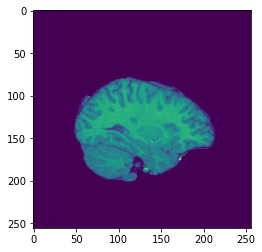

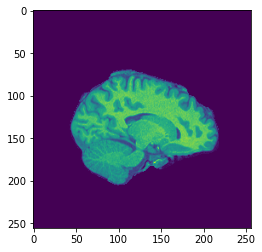

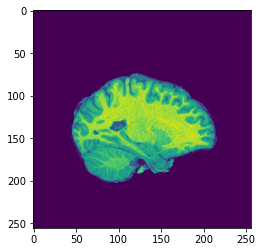

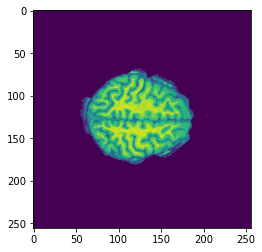

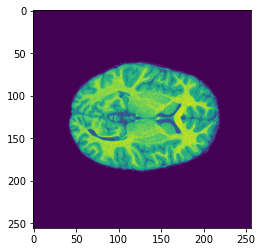

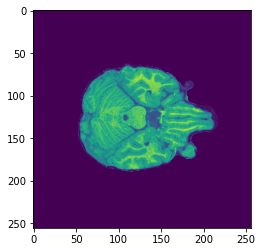

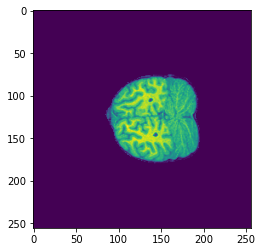

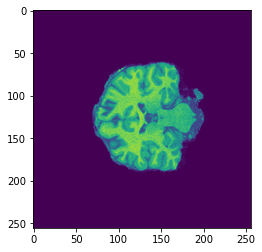

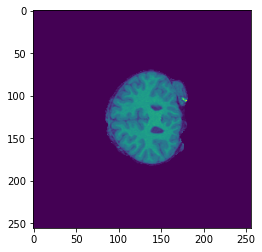

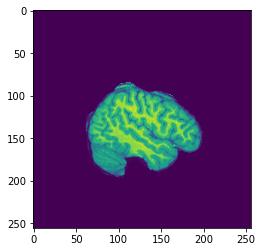

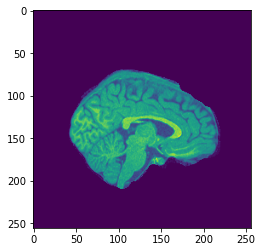

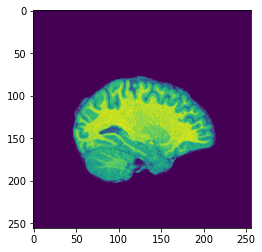

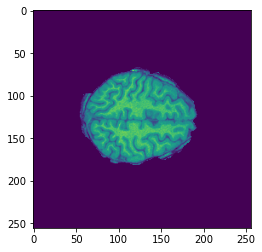

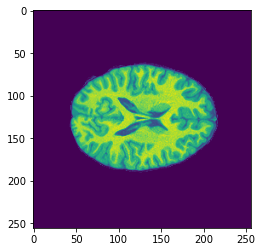

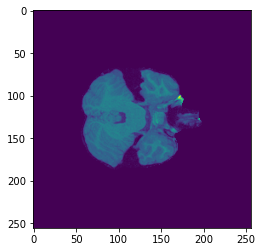

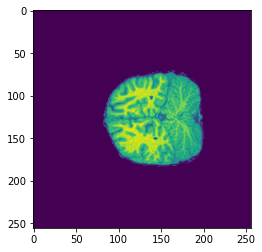

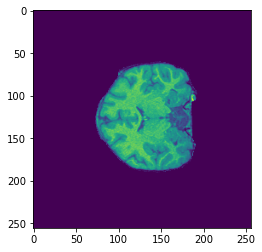

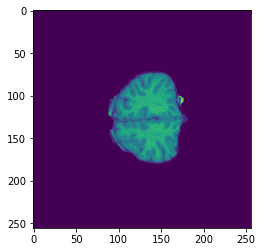

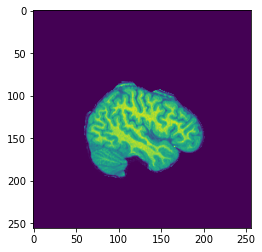

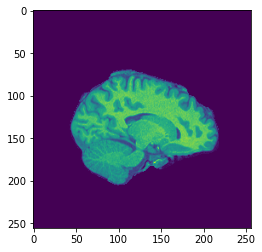

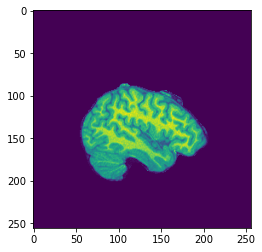

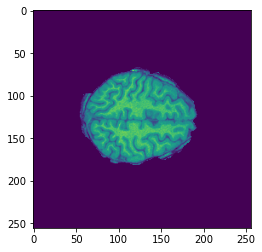

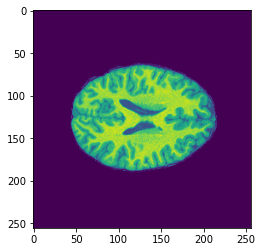

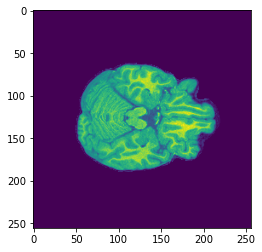

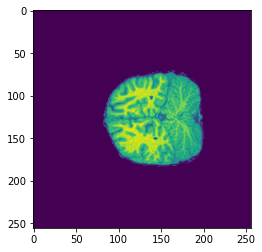

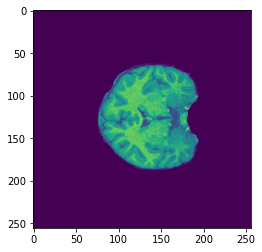

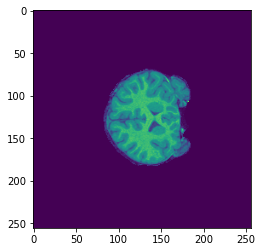

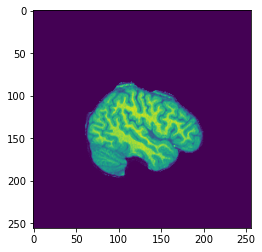

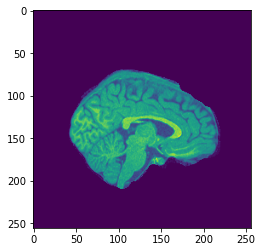

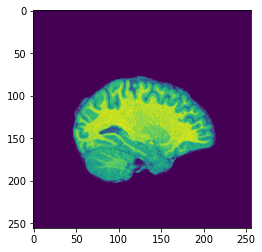

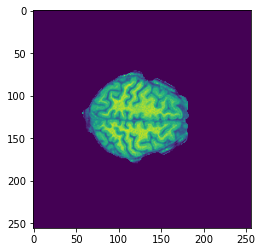

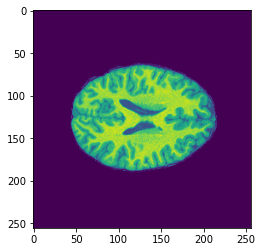

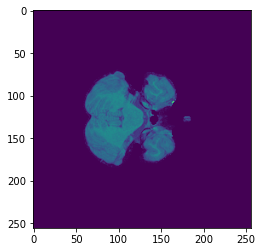

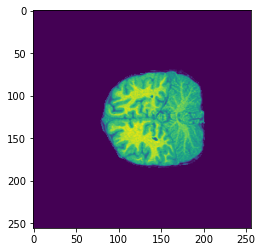

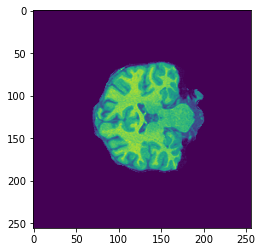

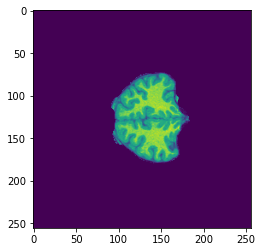

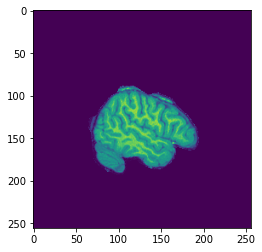

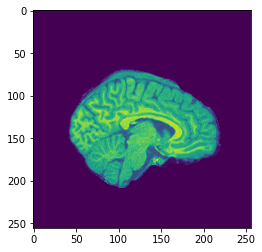

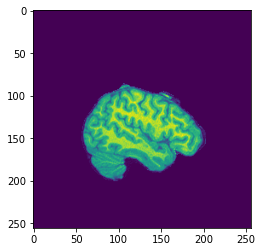

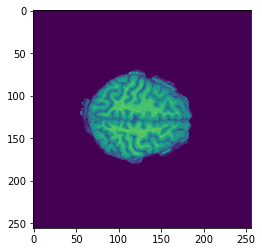

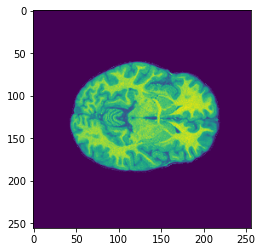

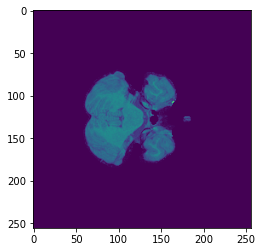

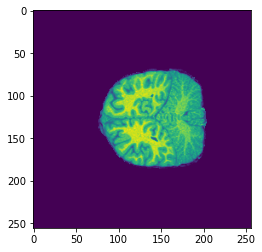

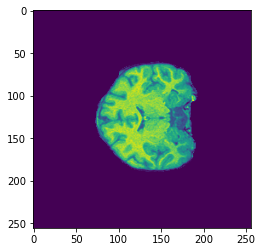

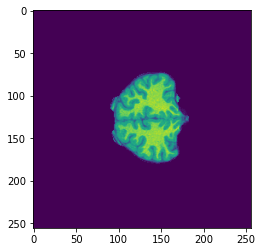

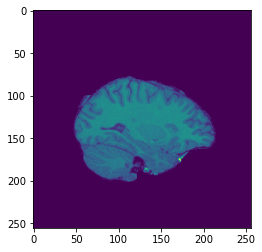

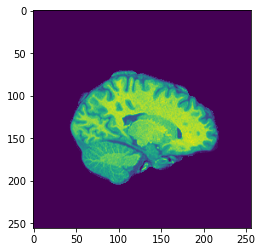

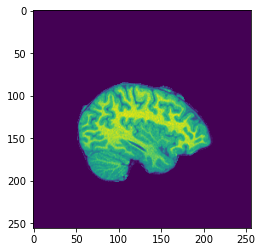

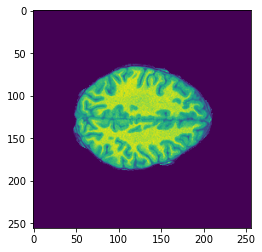

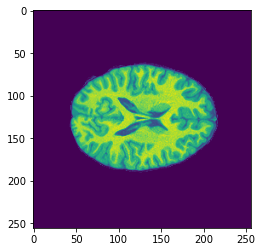

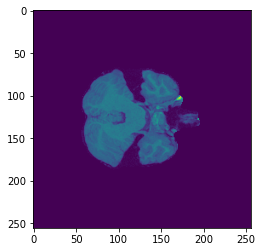

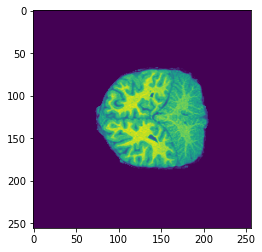

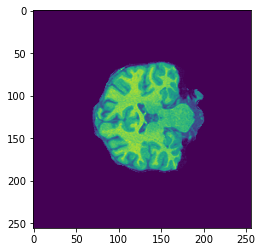

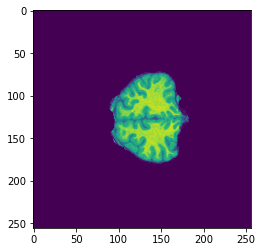

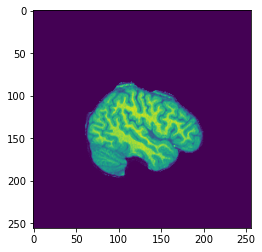

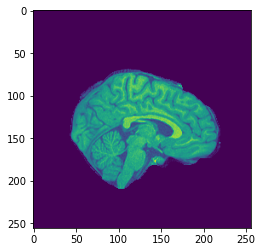

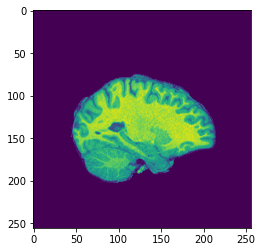

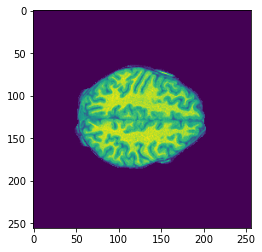

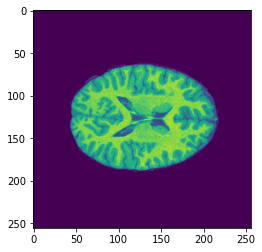

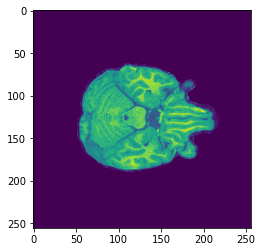

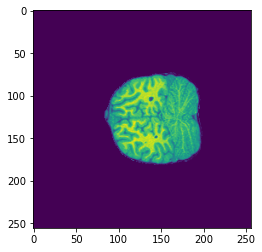

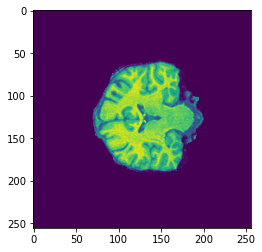

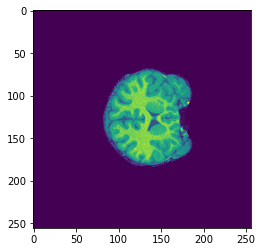

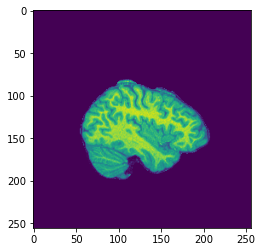

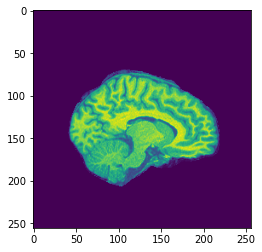

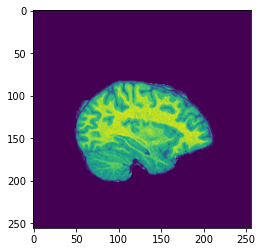

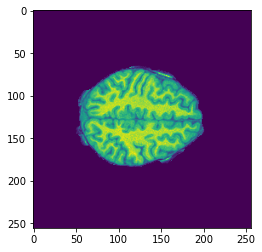

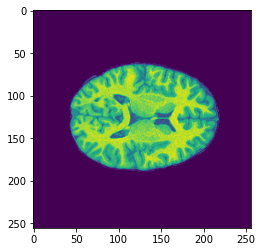

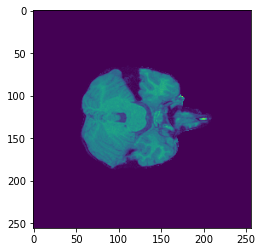

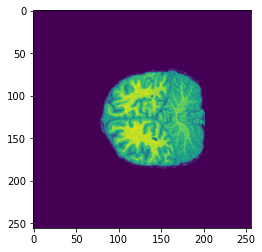

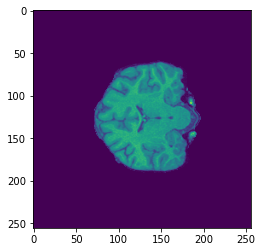

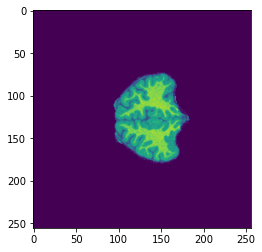

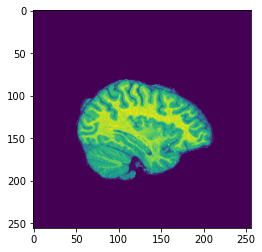

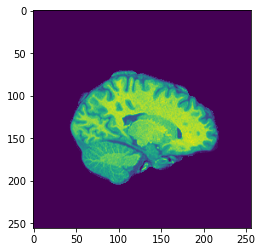

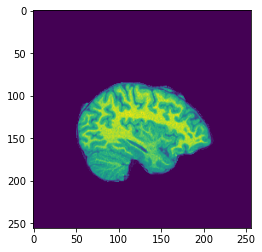

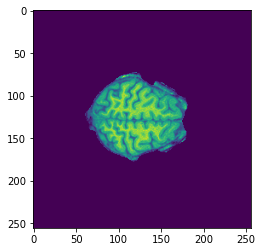

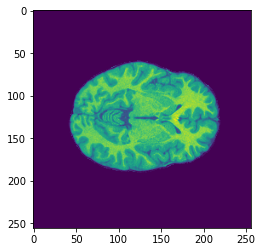

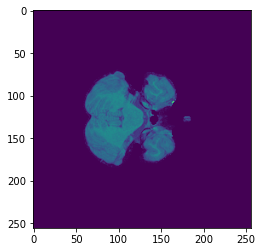

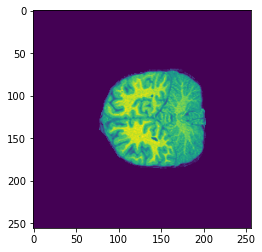

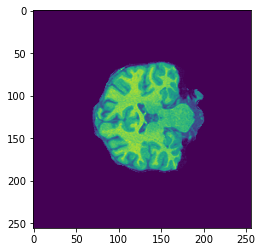

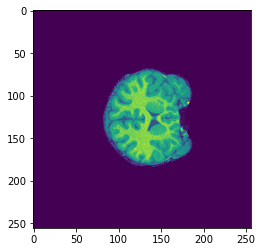

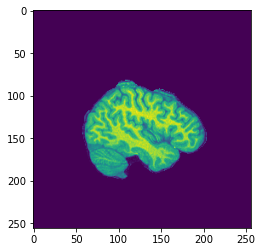

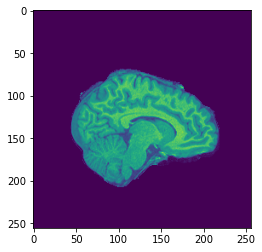

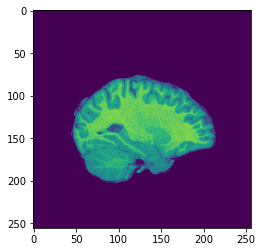

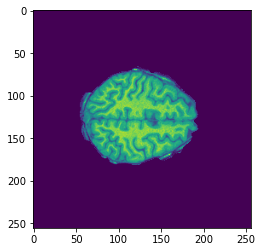

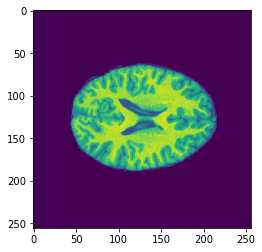

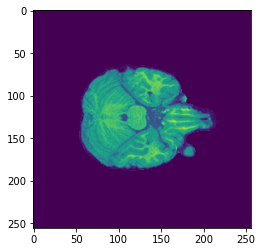

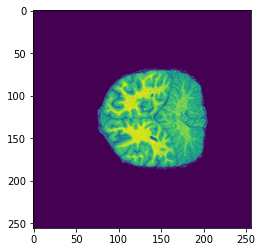

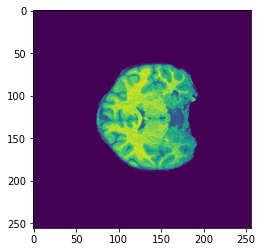

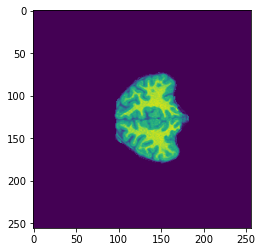

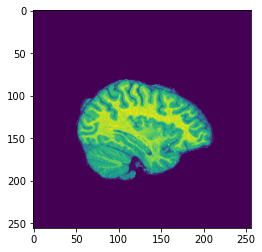

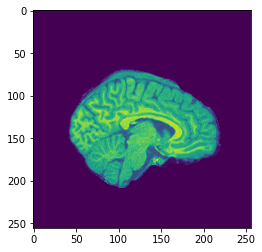

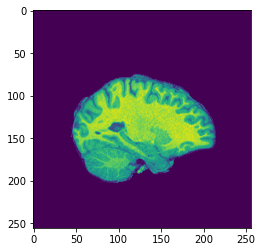

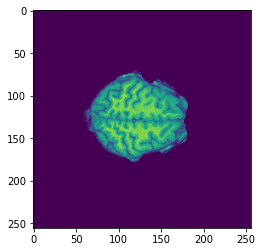

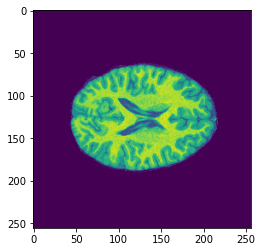

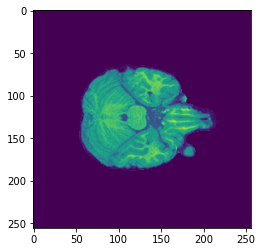

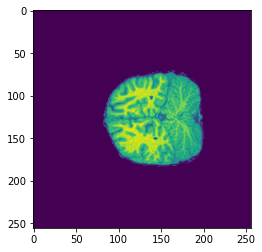

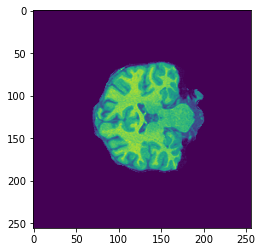

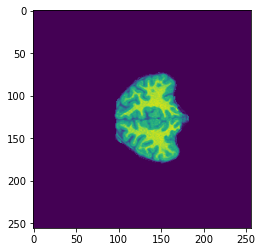

In [7]:
# Load the csv containing the list of the scans I want graded
fn = '/Users/youngjm/Data/clip/tables/CLIPv0.7/2022-05-26_highres_nocontrast_singlescanpersubject.csv'
df = pd.read_csv(fn)

outputDir = "/Users/youngjm/Data/clip/images/derivatives/qc_mpr_fs_6.0.0/"

# Get the ids of the scans we want graded
scanIds = df['scan_id'].values

# For each scan
for scanId in scanIds:
    # Identify the complete path to the scan
    subj = scanId.split("_")[0]
    ses = scanId.split("_")[1]
    
    scanPath = subjDir+subj+"/"+ses+"/anat/"+scanId+"/"
    generatePngsSingleScan(scanPath, subj, outputDir)
    
    

In [ ]:
df['scan_id'].values